<a href="https://colab.research.google.com/github/ShaoFuLiu/tSDRG_DataAnalysis/blob/master/TestSortingData_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **tSDRG Data Analysis**

### **Dim = Dimerization** 
### **Jdis = Randomness strength**
### **DimABC / JdisABC = Dimerization A.BC / Randomness strength A.BC**
### *example: Dim552 = Dimerization 5.52*

# **Import lib and set basic parameter**

In [1]:
## Import library
import os
import math
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [24]:
## Basic parameter
cnames = {                        
'blueviolet':           '#8A2BE2',
'brown':                '#A52A2A',
'burlywood':            '#DEB887',
'cadetblue':            '#5F9EA0',
'chocolate':            '#D2691E',
'crimson':              '#DC143C',
'cyan':                 '#00FFFF',
'darkblue':             '#00008B',
'darkcyan':             '#008B8B',
'darkolivegreen':       '#556B2F',
'darkorange':           '#FF8C00',
'darksalmon':           '#E9967A',
'darkseagreen':         '#8FBC8F',
'darkslateblue':        '#483D8B',
'darkslategray':        '#2F4F4F',
'darkturquoise':        '#00CED1',
'darkviolet':           '#9400D3',
'deeppink':             '#FF1493',
'deepskyblue':          '#00BFFF',
'dimgray':              '#696969',
'dodgerblue':           '#1E90FF',
'firebrick':            '#B22222',
'floralwhite':          '#FFFAF0',
'forestgreen':          '#228B22',
'fuchsia':              '#FF00FF',
'gainsboro':            '#DCDCDC',
'ghostwhite':           '#F8F8FF',
'gold':                 '#FFD700',
'greenyellow':          '#ADFF2F',
'honeydew':             '#F0FFF0',
'hotpink':              '#FF69B4',
'indianred':            '#CD5C5C',
'indigo':               '#4B0082',
'ivory':                '#FFFFF0',
'khaki':                '#F0E68C',
'orangered':            '#FF4500',
'orchid':               '#DA70D6'}
carr = []
for cmap in cnames.keys():                          ## color array
    carr.append(cmap)
marr = ['o-', 'x-', '^-', 's-', 'p-', '*-', 'h-']   ## marker array
spin = int(2)                                       ## Spin type
BC = 'PBC'
P = 10                                              ## Random distribution type (10 == Exponential distribution)
M = 40                                              ## Bound dimension 
font_size = 30

ALL_Dimer = ["Dim000"]
ALL_Jdis = ["Jdis000"]

Ddiff = 1
init_D = 0      ## Dim005 = 0.00
final_D = 100   ## Dim100 = 1.00
ds = (final_D - init_D)/Ddiff-1
for i in range (int(ds)+1):
    strD = "Dim00" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 10):
        strD = "Dim0" + str((i+1)*Ddiff+init_D)
    if ((i+1)*Ddiff+init_D >= 100):
        strD = "Dim" + str((i+1)*Ddiff+init_D) 
    ALL_Dimer.append(strD)

Jdiff = 1
init_J = 0      ## Jdis000 = 0.00
final_J = 600   ## Jdis600 = 6.00
js = (final_J - init_J)/Jdiff-1
for i in range (int(js)+1):
    strJ = "Jdis00" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 10):
        strJ = "Jdis0" + str((i+1)*Jdiff+init_J)
    if ((i+1)*Jdiff+init_J >= 100):
        strJ = "Jdis" + str((i+1)*Jdiff+init_J)
    ALL_Jdis.append(strJ)
# print(ALL_Dimer) ## ALL_Dimer = [Dim000, Dim001, ... , Dim099, Dim100]
# print(ALL_Jdis)  ## ALL_Jdis = [Jdis000, Jdis001, ... , Jdis599, Jdis600]


# **Define function**

In [3]:
def find_id(f_diff):                ## find crossing point index
    ids = []
    for id in range(len(f_diff)-1):
        if (np.sign(f_diff['diff'][id]) != np.sign(f_diff['diff'][id+1])):
            ids.append(id)
    if (len(ids) == 0):
        raise ValueError('no crossing point')
    return ids

def fitting_point(f_L1, f_L2, ids, var, para, n_point):
    x = []
    y = []
    for id in ids:   
        id_range = range(id-int(n_point/2-1), id+int(n_point/2)) ## use n point to fit (id-(n/2-1), ... id, ..., id+(n/2))

        a1, b1  = np.polyfit(f_L1[var][id_range], f_L1[para][id_range], 1)
        a2, b2  = np.polyfit(f_L2[var][id_range], f_L2[para][id_range], 1)
        x0 = (b2-b1)/(a1-a2)
        y0 = a1*x0 + b1
        x.append(x0)
        y.append(y0)
    return x,y

# **Plot**

## Fix **<font color = yellow>J</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = green>D</font>**, Multiplot (2021/11/25)

### **<font color = yellow>J</font>** = 0 ~ 0.7

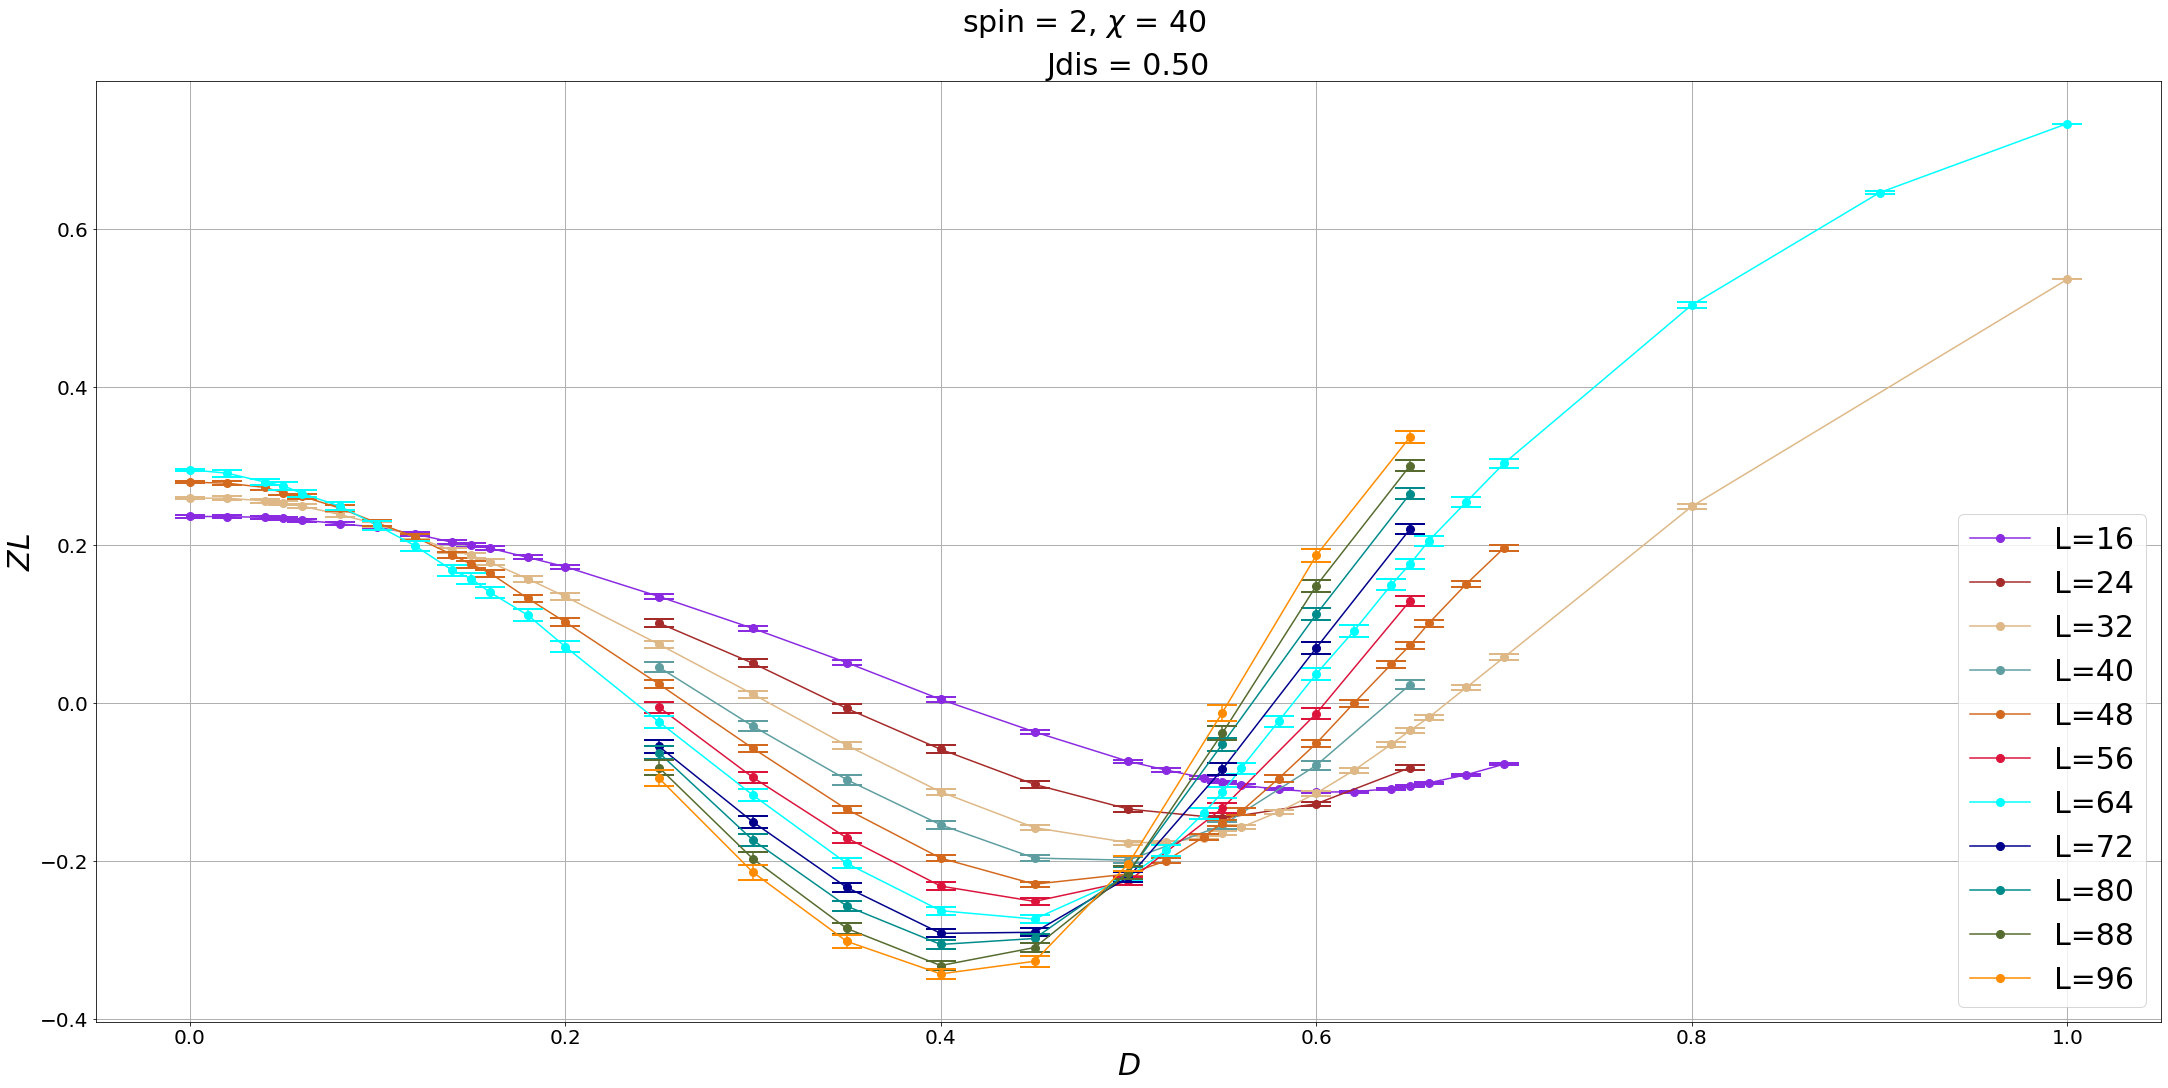

In [67]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,88,96]             ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis050"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(30,15))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        ax.plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 8, label = 'L=%d' %(L))
        ax.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax.set_xlabel(r'$D$', fontsize=30)
        ax.set_ylabel(ylable, fontsize=30)
        ax.tick_params(axis='x', labelsize=20) 
        ax.tick_params(axis='y', labelsize=20)
        ax.set_title("Jdis = %.2f" %(J), fontsize=30)
        ax.grid(linestyle='-', linewidth=1)
        # ax.set_xlim([0.45, 0.65])
        # ax.set_ylim([-0.3, 0.2])
        ax.legend(loc = 'best',fontsize=30)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=30)
# fig.legend(lines, labels, fontsize=30)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

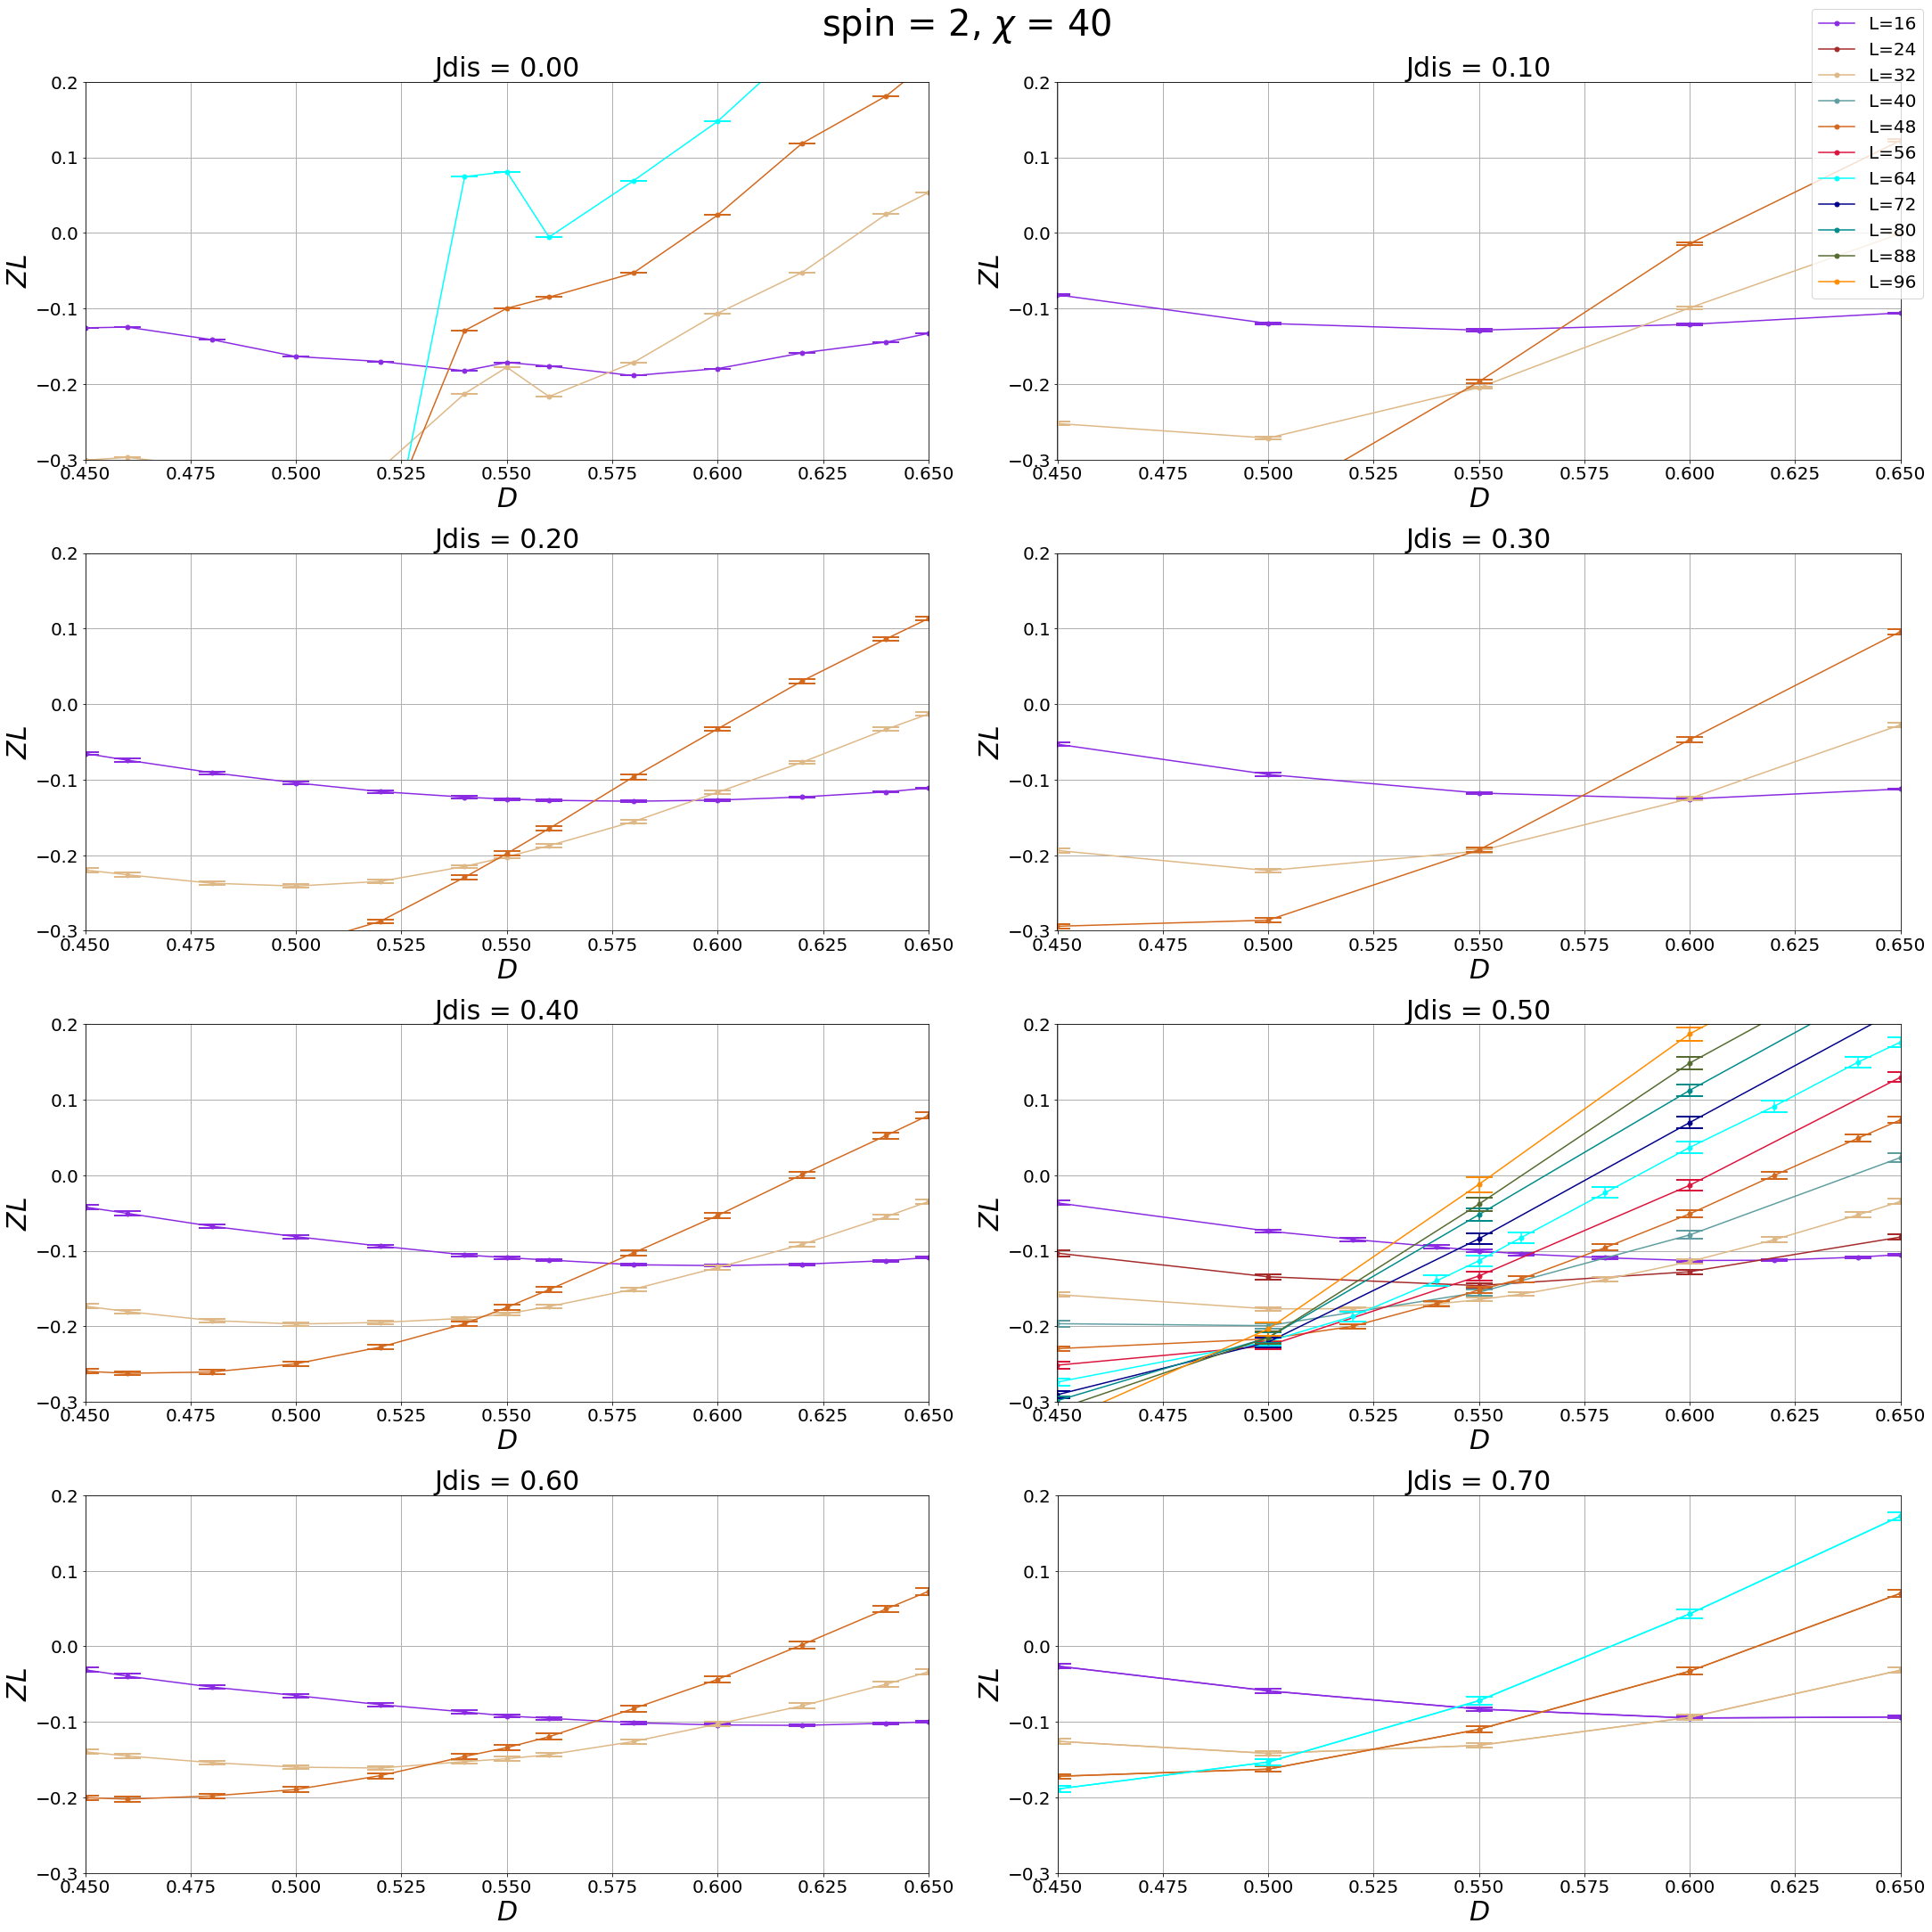

In [62]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,88,96]             ## Choose size 
# Ls = [16,32,48,64]
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], "o-", color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=15, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0.45, 0.65])
        ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.3, 0.2])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show() 

/home/liusf/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


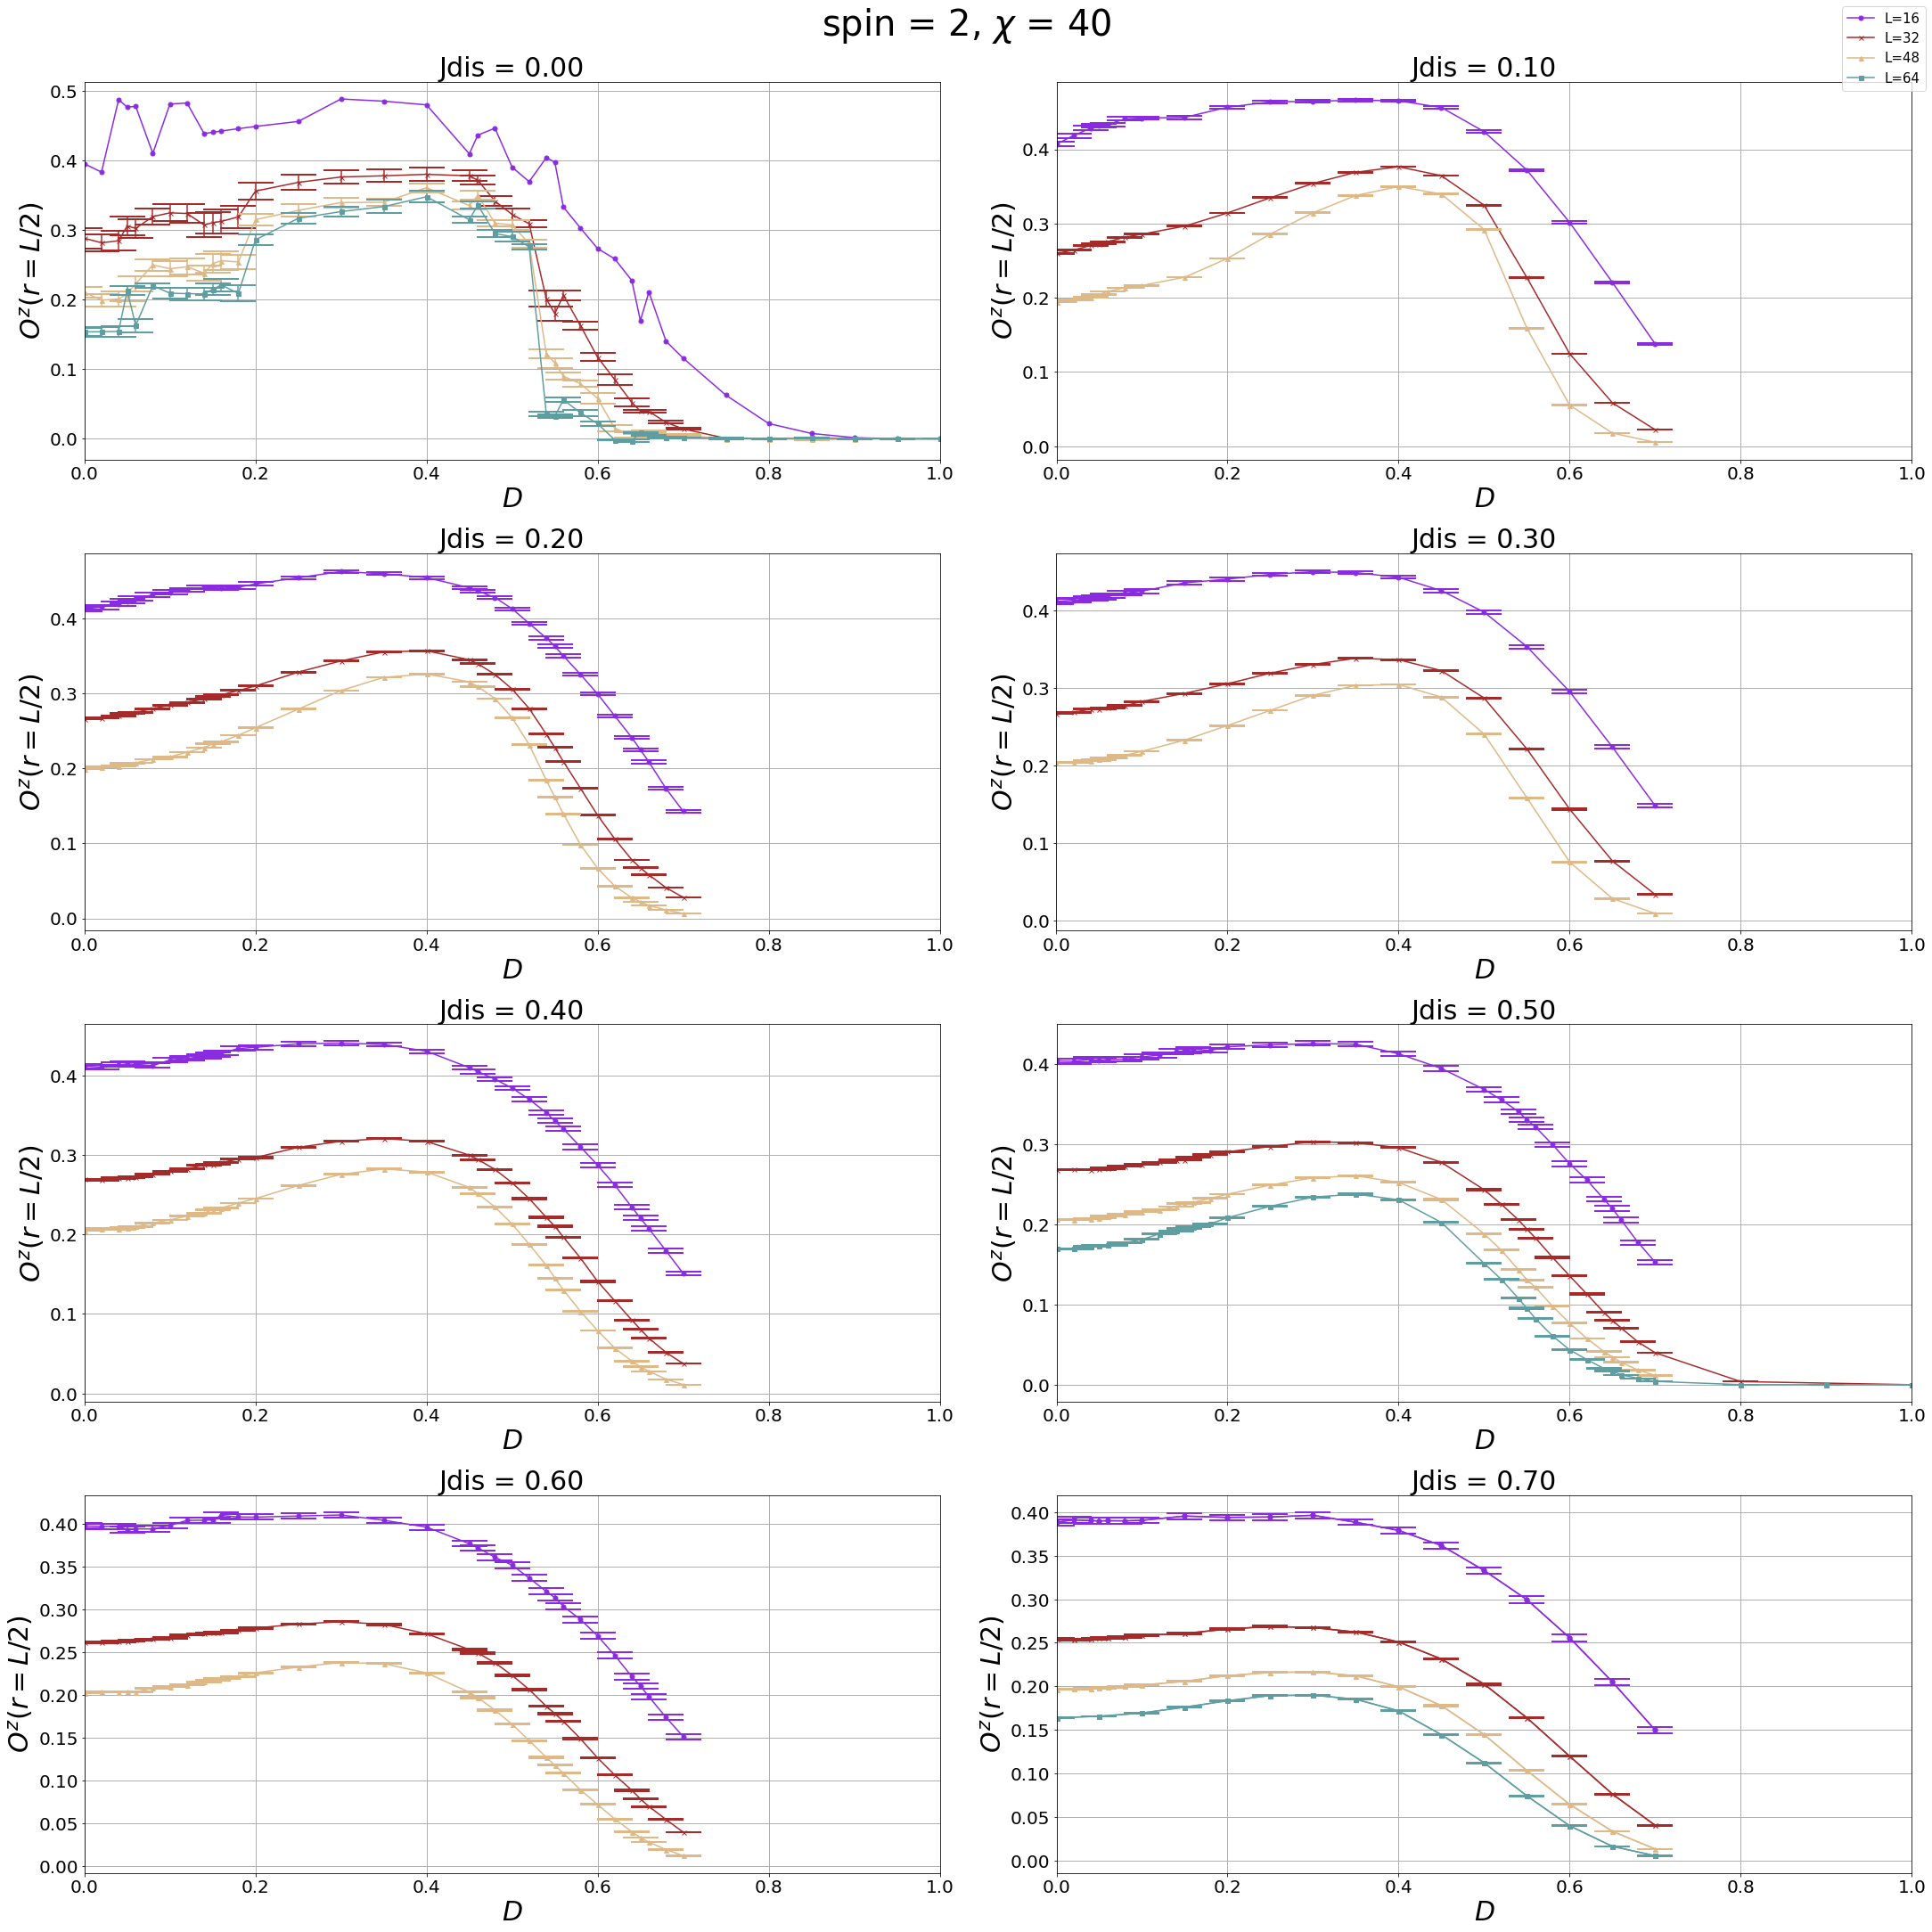

In [81]:
# 固定J, 看L, Oz 對 D 的圖(橫切)
OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis000","Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0., 1])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.25])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

### **<font color = yellow>J</font>** = 0.8 ~ 1.5

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64]              ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis080","Jdis090","Jdis100","Jdis110","Jdis120","Jdis130","Jdis140","Jdis150"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.2])
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0.15, 0.225])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定J, 看L, Oz 對 D 的圖(橫切)

OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]              ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis080","Jdis090","Jdis100","Jdis110","Jdis120","Jdis130","Jdis140","Jdis150"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.15, 0.1])
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 1])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

### **<font color = yellow>J</font>** = 2 ~ 5.5

In [ ]:
# 固定J, 看L, ZL 對 D 的圖(橫切)

OrderPara = "ZL"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.25])                      ## set y limit (For Oz)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.01, 0.03])                  ## set y limit (For ZL)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.6])                       ## set x limit (For ZL)
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

In [ ]:
# 固定J, 看L, Oz 對 D 的圖(橫切)

OrderPara = "SOP"                ## Choose SOP or ZL
Ls = [16,32,48,64]               ## Choose size 
Dimer = ALL_Dimer
Jdis = ["Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550"]

# fig, ax = plt.subplots(4, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,30)) ## fix same x, y axis
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): ## Some data is not ok, so we need to ignore it.
                continue

            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        if (j == len(Jdis)-1):
           ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$D$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.25])                      ## set y limit (For Oz)
        # ax[int(j/2)][j-2*int(j/2)].set_ylim([-0.01, 0.03])                  ## set y limit (For ZL)
        # ax[int(j/2)][j-2*int(j/2)].set_xlim([0, 0.6])                       ## set x limit (For ZL)
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=10)
            
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

### **fitting and find crossing point (橫切)**

In [ ]:
# fitting (polyfit) and find crossing point 
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)

Ls = [16,32,48]
Jdis = ["Jdis050"]
Dimer = ALL_Dimer

for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])    
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[d] = mean

        mask1 = dfplt["Dimer"] > 0.14  ## 指定fitting範圍
        mask2 = dfplt["Dimer"] < 0.21  ## 指定fitting範圍

        fit_dfplt = dfplt[mask1 & mask2]

    f1 = np.polyfit(fit_dfplt['Dimer'], fit_dfplt[Para], 1)
    p1 = np.poly1d(f1)
    yvals = np.polyval(f1, dfplt['Dimer'])
    
    ax = plt.subplot(111)
    #修改主刻度
    xmajorLocator = MultipleLocator(0.1) #將x主刻度標籤設置為20的倍數
    xmajorFormatter = FormatStrFormatter('%5.1f') #設置x軸標籤文本的格式
    #設置主刻度標籤的位置,標籤文本的格式
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_major_formatter(xmajorFormatter)
    #修改次刻度
    xminorLocator = MultipleLocator(0.01) #將x軸次刻度標籤設置為5的倍數
    ax.xaxis.set_minor_locator(xminorLocator)
    # plt.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l], markersize = font_size/3, label = 'L=%d' %(L)) ## original data plot
    plt.plot(dfplt['Dimer'], yvals, "-", color=carr[l], markersize = font_size/3, linewidth = font_size/15, label = 'L=%d' %(L)) ## fitting data plot

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.15, 0.25)
# plt.ylim(0.1, 0.3)
# plt.grid(linestyle='-', linewidth=1)
ax.xaxis.grid(True, which='both') #x坐標軸的網格使用主次刻度
ax.yaxis.grid(True, which='major') #y坐標軸的網格使用主刻度
plt.title('spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **fitting and find crossing point (橫切) version2 (2021/11/25)**


-------------------- J = 0.5 --------------------
         D1                   D2
L24-L16 [0.618207930255041]
L32-L24 [0.5784674596340471]
L40-L32 [0.5353531407903929]
L48-L40 [0.5432867104483421]
L56-L48 [0.5105830359220656]
L64-L56 [0.49325929285418085]
L72-L64 [0.4915813054900915]
L80-L72 [0.4767857431116099]
L88-L80 [0.49748564132616446]
L96-L88 [0.4753116584115364]


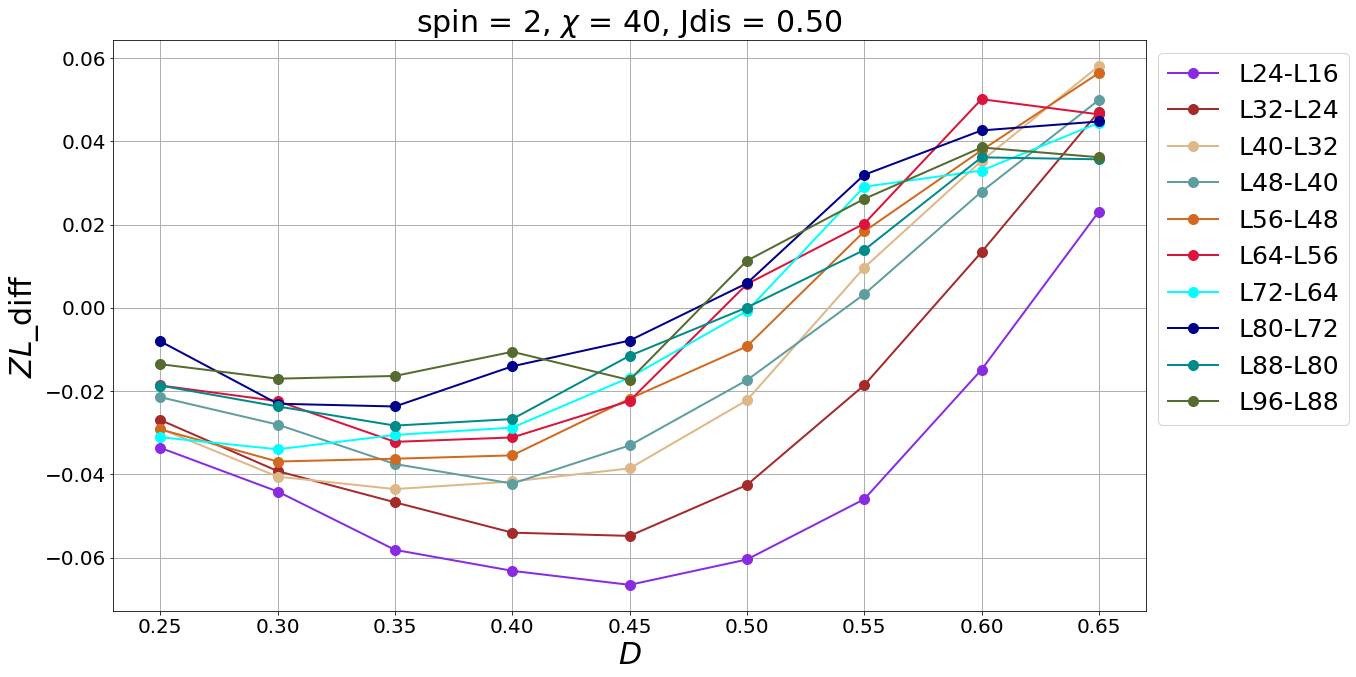

In [32]:
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$_diff', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$_diff', fontsize=font_size)

Ls = [16,24,32,40,48,56,64,72,80,88,96]
# Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060"]
Jdis = ["Jdis050"]
Dimer = ALL_Dimer[25:66]
n_point = 4

for j in range(len(Jdis)):
    jdis = Jdis[j]
    J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
    print("\n-------------------- J = "+ str(J) +" --------------------")
    print("         D1", "                  D2")
    D1 = []
    D2 = []

    for l in range(len(Ls)-1):
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Dimer', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Dimer', 'diff'])
        ignore_num = 0

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        
            file_L1 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            file_L2 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                    ignore_num += 1
                    continue
            
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            if (OrderPara == "SOP"):
                mean_L1 = {'Dimer':D, 'ZL':-df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':-df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L1[Para][0]-df_L2[Para][0]}
            else:
                mean_L1 = {'Dimer':D, 'ZL':df_L1[Para][0]}
                mean_L2 = {'Dimer':D, 'ZL':df_L2[Para][0]}
                mean_diff = {'Dimer':D, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[d-ignore_num] = mean_L1
            f_L2.loc[d-ignore_num] = mean_L2
            f_diff.loc[d-ignore_num] = mean_diff

        plt.plot(f_diff['Dimer'], f_diff['diff'], "o-", color=carr[l], markersize = font_size/3, linewidth = font_size/15, label = 'L%d-L%d' %(L2,L1))

        ids = find_id(f_diff)
        Ds, ys = fitting_point(f_L1, f_L2, ids, "Dimer", Para, n_point)
        print(("L"+str(L2)+"-"+"L"+str(L1)), Ds)
        D1.append(Ds[0])
        # D2.append(Ds[1])

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.4, 0.7)
# plt.ylim(0.1, 0.3)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

#### **D(crossing point) vs 1/L (2021/11/25)**

No handles with labels found to put in legend.


[0.618207930255041, 0.5784674596340471, 0.5353531407903929, 0.5432867104483421, 0.5105830359220656, 0.49325929285418085, 0.4915813054900915, 0.4767857431116099, 0.49748564132616446, 0.4753116584115364]


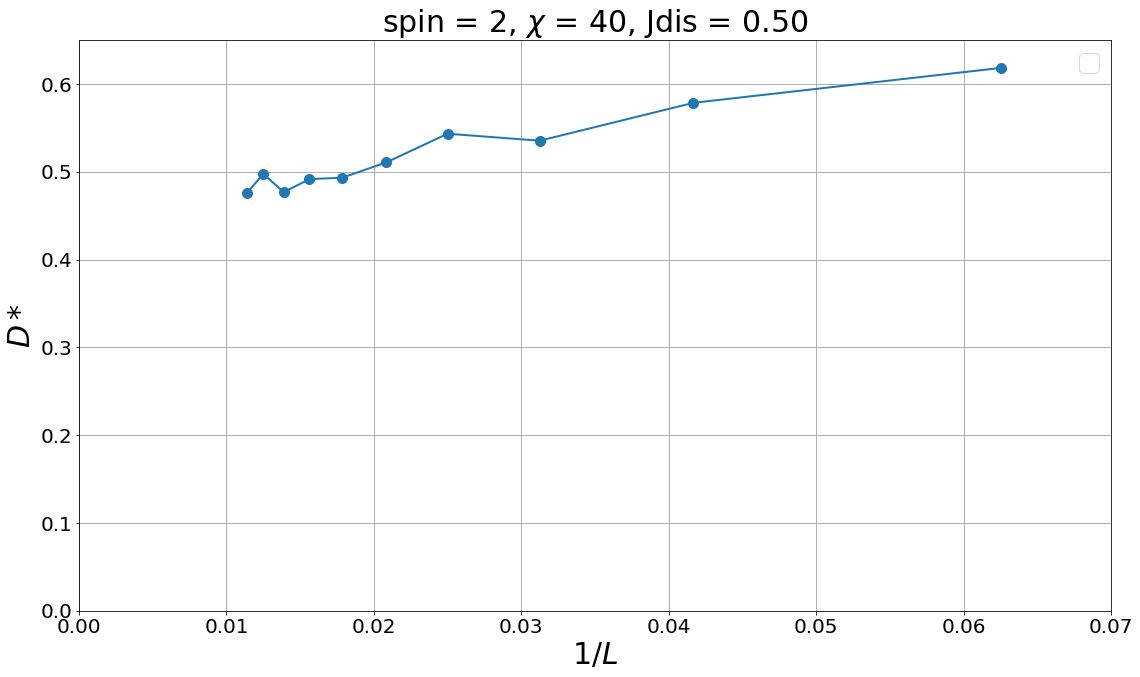

In [33]:
print(D1)
x = []
for l in range(len(Ls)-1):
    x.append(1/Ls[l])
    
plt.plot(x, D1, "o-", markersize = font_size/3, linewidth = font_size/15)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.ylabel(r'$D*$', fontsize=font_size)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.xlim(0., 0.07)
plt.ylim(0, 0.65)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Jdis = %.2f' % (spin, M, J), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = green>D</font>**, look **<font color = red>L</font>**, **Order Parameter** vs **<font color = yellow>J</font>**, Multiplot (2021/11/25)

### **<font color = green>D</font>** = 0 ~ 0.12

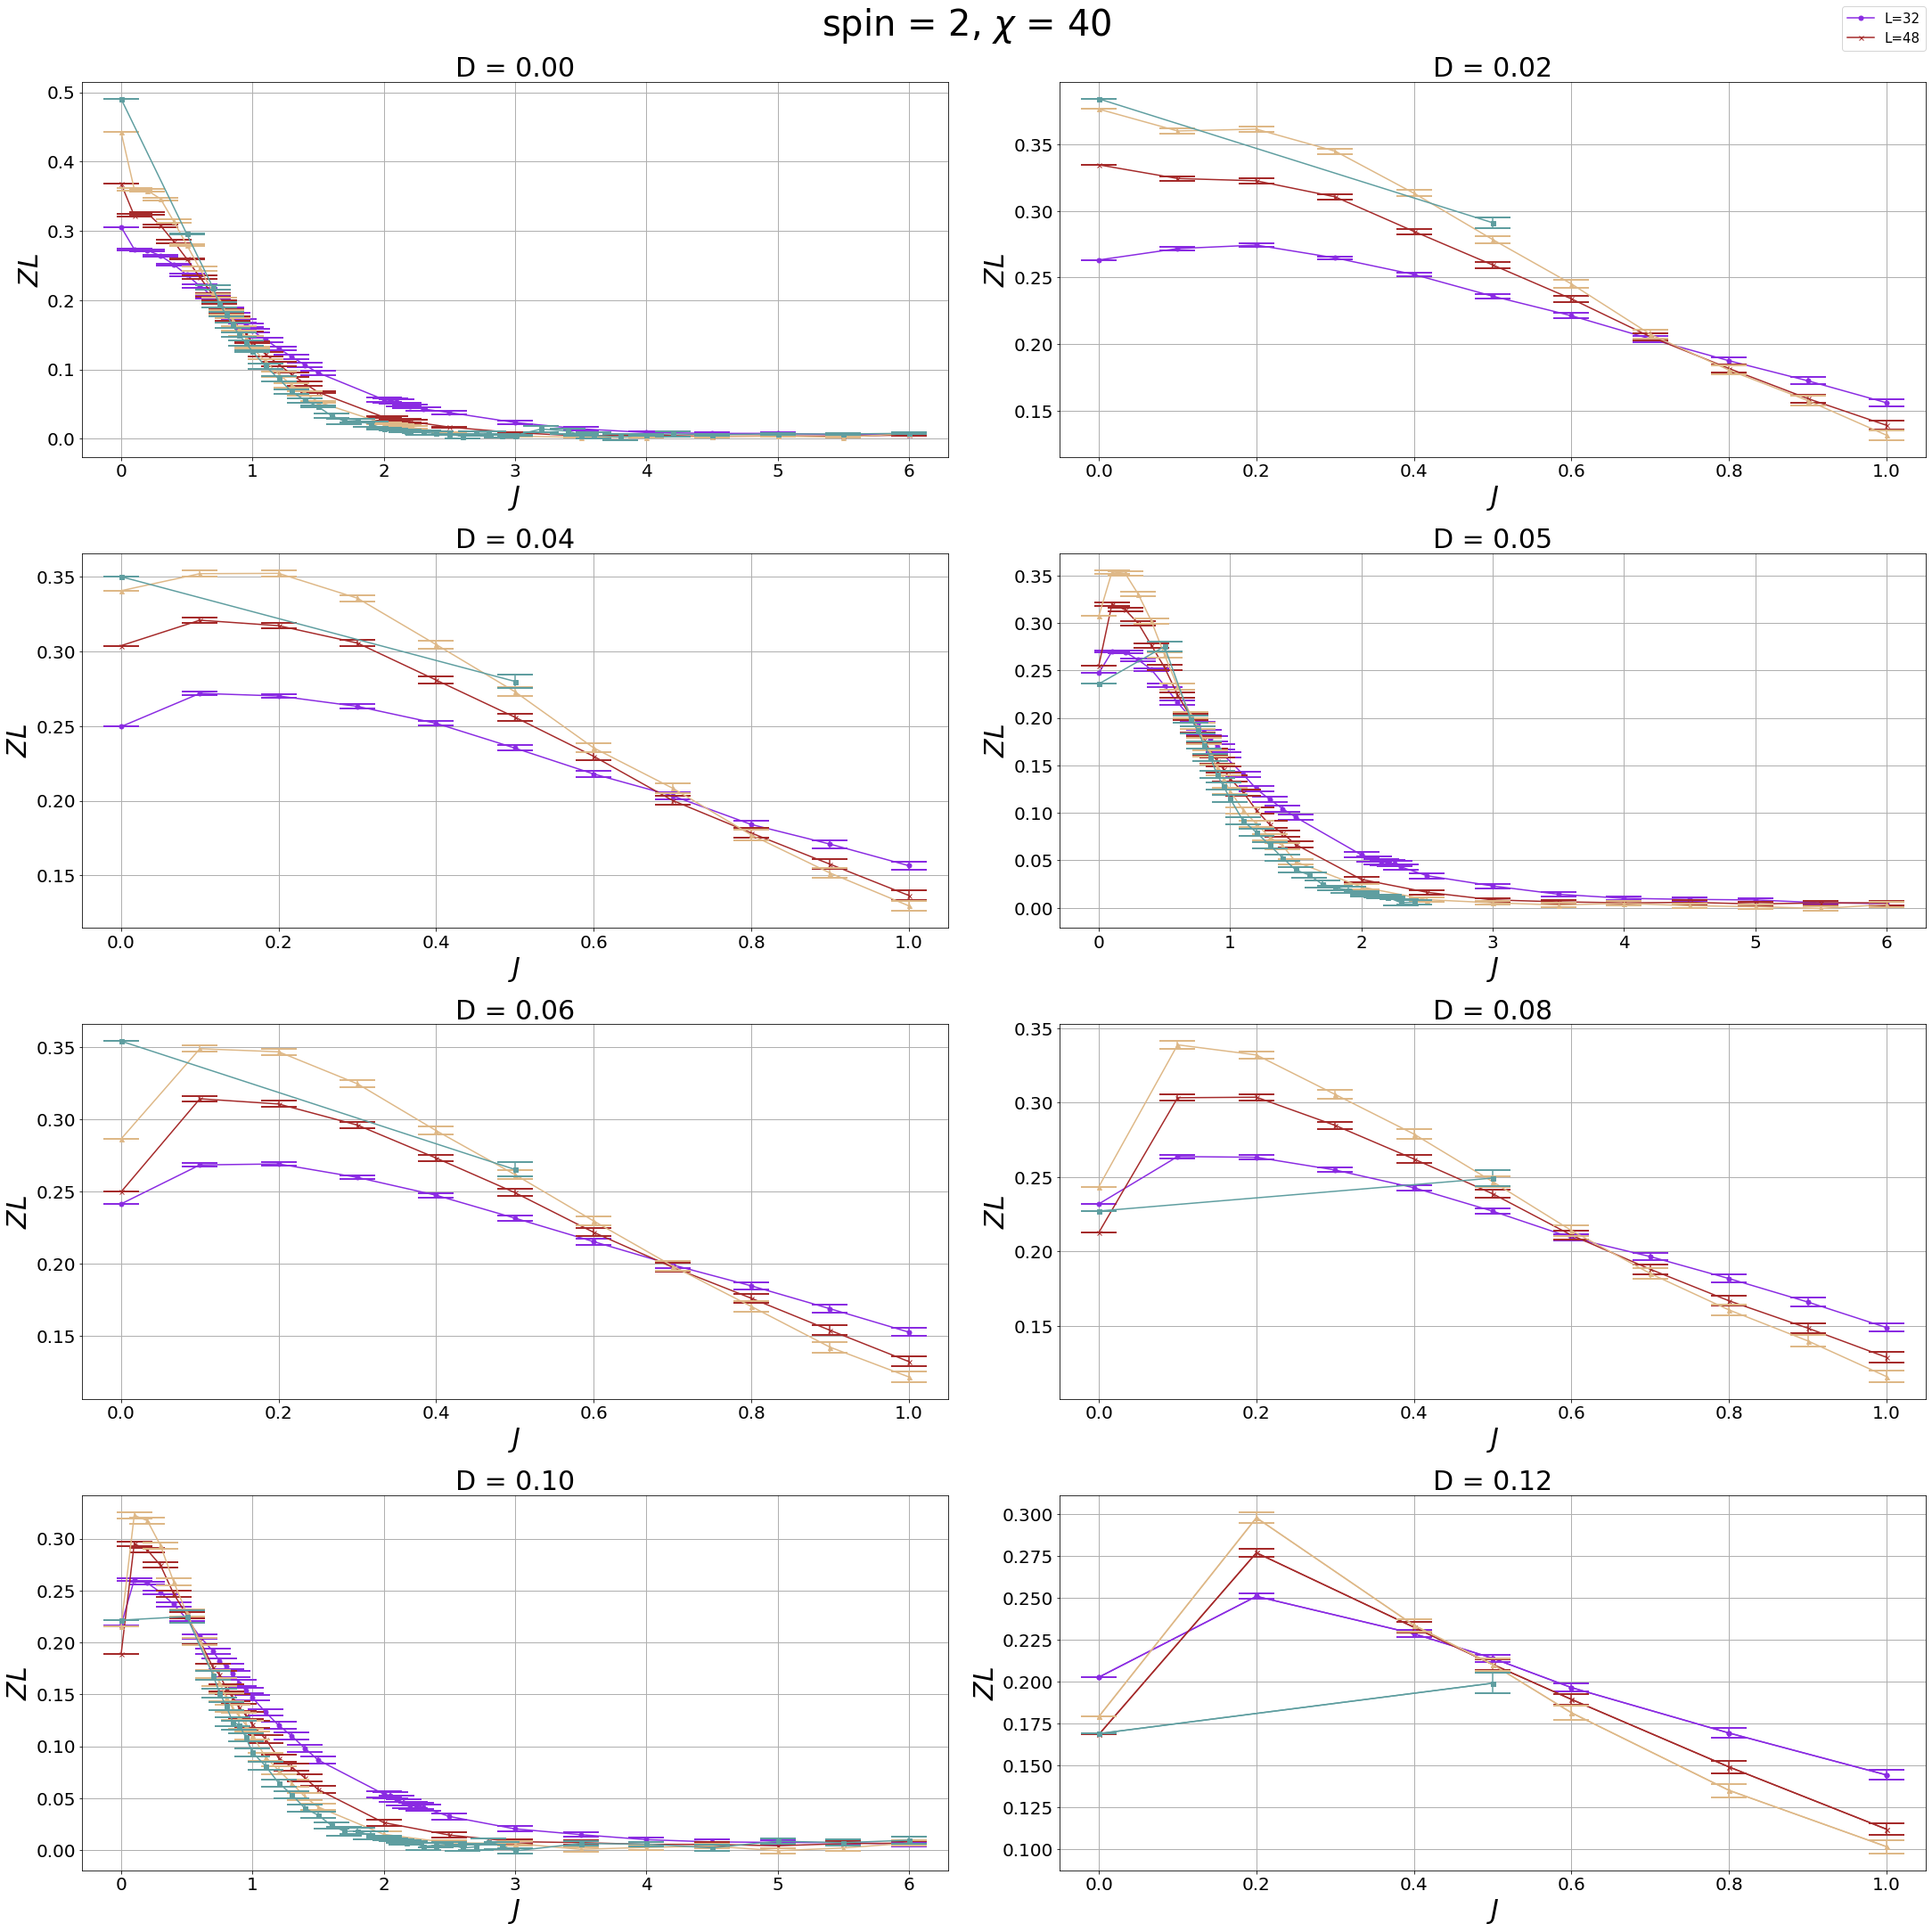

In [174]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim000","Dim002","Dim004","Dim005","Dim006","Dim008","Dim010","Dim012"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim000","Dim002","Dim004","Dim005","Dim006","Dim008","Dim010","Dim012"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.14 ~ 0.4

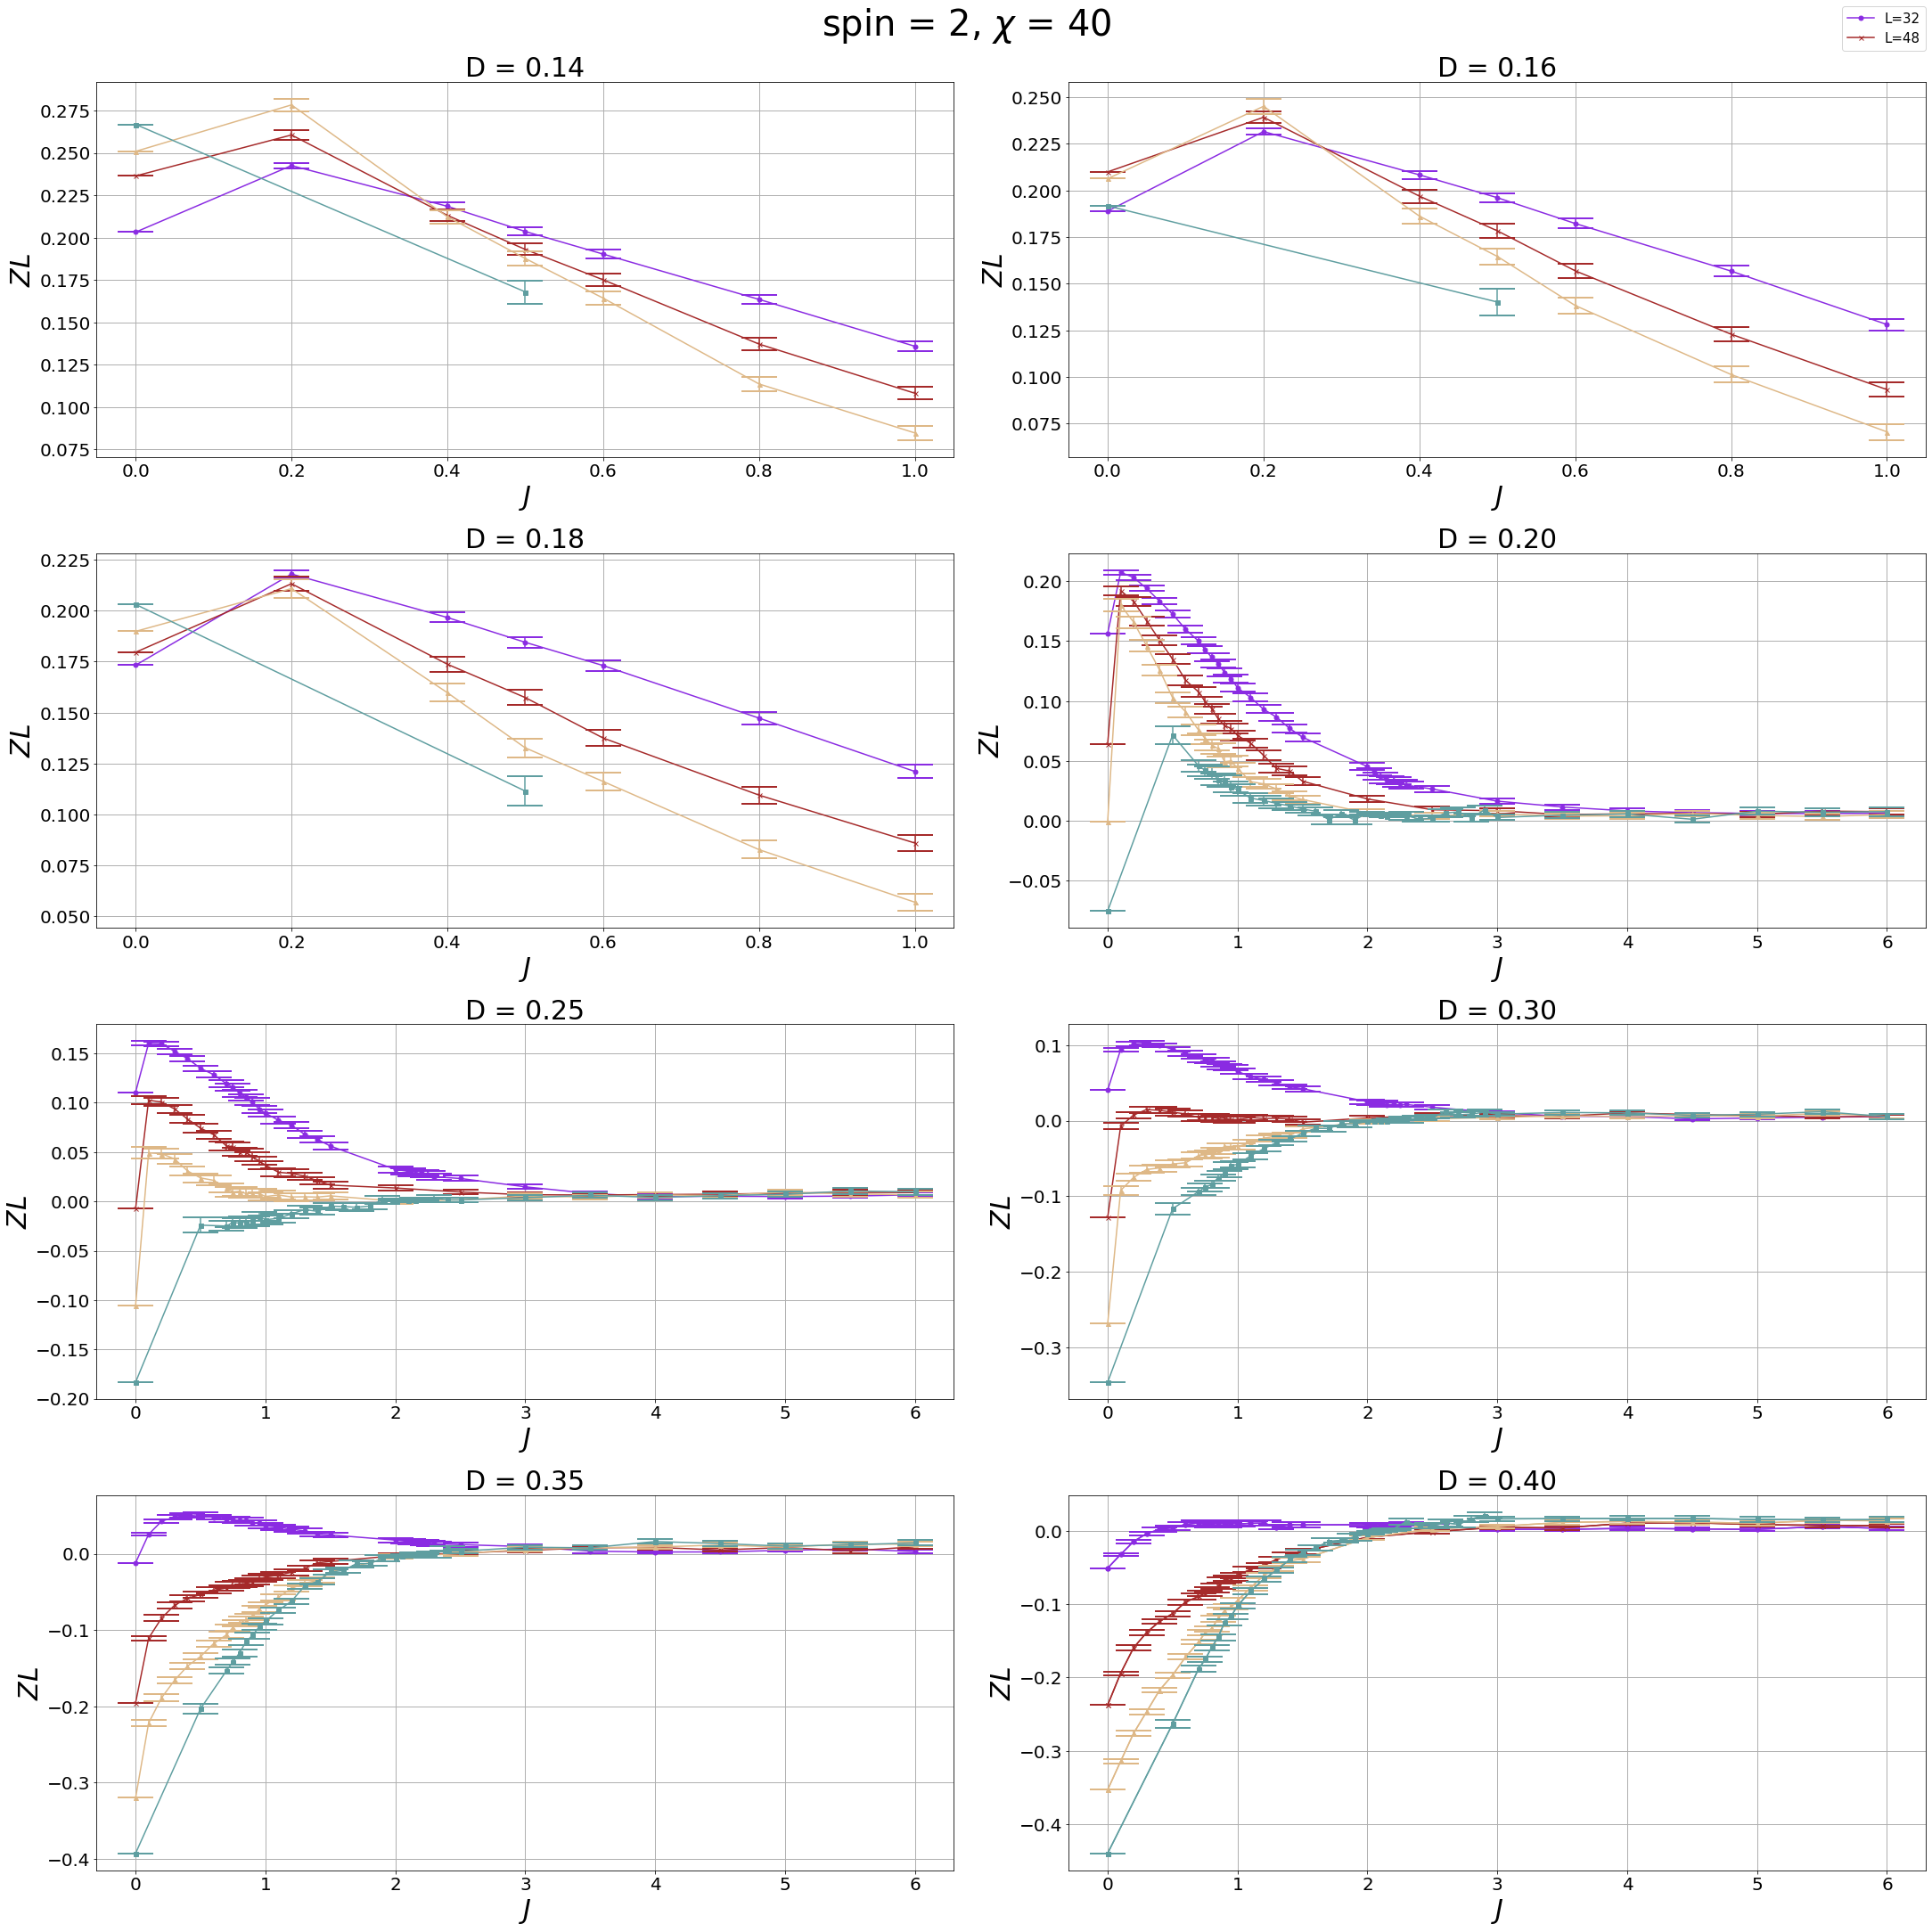

In [171]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim014","Dim016","Dim018","Dim020","Dim025","Dim030","Dim035","Dim040"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim014","Dim016","Dim018","Dim020","Dim025","Dim030","Dim035","Dim040"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show() 

### **<font color = green>D</font>** = 0.45 ~ 0.56

In [ ]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim045","Dim046","Dim048","Dim050","Dim052","Dim054","Dim055","Dim056"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim045","Dim046","Dim048","Dim050","Dim052","Dim054","Dim055","Dim056"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

### **<font color = green>D</font>** = 0.58 ~ 0.7

In [ ]:
# 固定D, 看L, ZL 對 J 的圖(直切)

OrderPara = "ZL"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim058","Dim060","Dim062","Dim064","Dim065","Dim066","Dim068","Dim070"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

In [ ]:
# 固定D, 看L, Oz 對 J 的圖(直切)

OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,32,48,64]
Dimer = ["Dim058","Dim060","Dim062","Dim064","Dim065","Dim066","Dim068","Dim070"]

Jdis = ALL_Jdis
# Jdis = ["Jdis000","Jdis050","Jdis100","Jdis150","Jdis200","Jdis250","Jdis300","Jdis350","Jdis400","Jdis450","Jdis500","Jdis550","Jdis600"]
# fig, ax = plt.subplots(2, 2, sharex='col',sharey='row', constrained_layout=True, figsize=(30,15)) ## 同軸設定
fig, ax = plt.subplots(4, 2, constrained_layout=True, figsize=(30,30))

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'
    
for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)
            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        if (d == len(Dimer)-1):
           ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5, label = 'L=%d' %(L))

        ax[int(d/2)][d-2*int(d/2)].plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = 5)
        ax[int(d/2)][d-2*int(d/2)].errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[l], label=None)
        ax[int(d/2)][d-2*int(d/2)].set_xlabel(r'$J$', fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].set_ylabel(ylable, fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='x', labelsize=20) 
        ax[int(d/2)][d-2*int(d/2)].tick_params(axis='y', labelsize=20)
        ax[int(d/2)][d-2*int(d/2)].set_title("D = %.2f" %(D), fontsize=30)
        ax[int(d/2)][d-2*int(d/2)].grid(linestyle='-', linewidth=1)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1.5])                       ## set x limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([0, 0.05])                      ## set y limit (For Oz, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_xlim([0, 1])                         ## set x limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].set_ylim([-0.025, 0.025])                ## set y limit (For ZL, spin2)
        # ax[int(d/2)][d-2*int(d/2)].legend(loc = 'best',fontsize=10)
            
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# fig.tight_layout()
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

### **fitting and find crossing point (直切)**

In [ ]:
# fitting (polyfit) and find crossing point 
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)

Ls = [16,32,48]
Dimer = ["Dim018"]
Jdis = ALL_Jdis

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                    # print(dimer + ' does not exist!!!')
                    continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP"):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}    
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]} 

            dfplt.loc[j] = mean

        mask1 = dfplt["Jdis"] > 0.09  ## 指定fitting範圍
        mask2 = dfplt["Jdis"] < 0.51 ## 指定fitting範圍

        fit_dfplt = dfplt[mask1 & mask2]

    f1 = np.polyfit(fit_dfplt['Jdis'], fit_dfplt[Para], 1)
    yvals=np.polyval(f1, dfplt['Jdis'])
    
    ax = plt.subplot(111)
    #修改主刻度
    xmajorLocator = MultipleLocator(1) #將x主刻度標籤設置為20的倍數
    xmajorFormatter = FormatStrFormatter('%5.1f') #設置x軸標籤文本的格式
    #設置主刻度標籤的位置,標籤文本的格式
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_major_formatter(xmajorFormatter)
    #修改次刻度
    xminorLocator = MultipleLocator(0.1) #將x軸次刻度標籤設置為5的倍數
    ax.xaxis.set_minor_locator(xminorLocator)
    # plt.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l], markersize = font_size/3, label = 'L=%d' %(L)) ## real data plot
    plt.plot(dfplt['Jdis'], yvals, "-", color=carr[l], markersize = font_size/3, linewidth = font_size/15, label = 'L=%d' %(L)) ## fitting data plot

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.xlim(0, 1)
plt.ylim(0, 0.5)
# plt.grid(linestyle='-', linewidth=1)
ax.xaxis.grid(True, which='both') #x坐標軸的網格使用主次刻度
ax.yaxis.grid(True, which='major') #y坐標軸的網格使用主刻度
plt.title('spin = %s, $\chi$ = %d, D = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **fitting and find crossing point (直切) version2 (2021/11/25)**


-------------------- D = 0.0 --------------------
         J1                   J2
L32-L16 [0.7473109199762229]
L48-L32 [0.7832207186647825, 5.452893961819169]

-------------------- D = 0.05 --------------------
         J1                   J2
L32-L16 [0.6941736256007688, 5.726500749943859]
L48-L32 [0.7804394799685327]


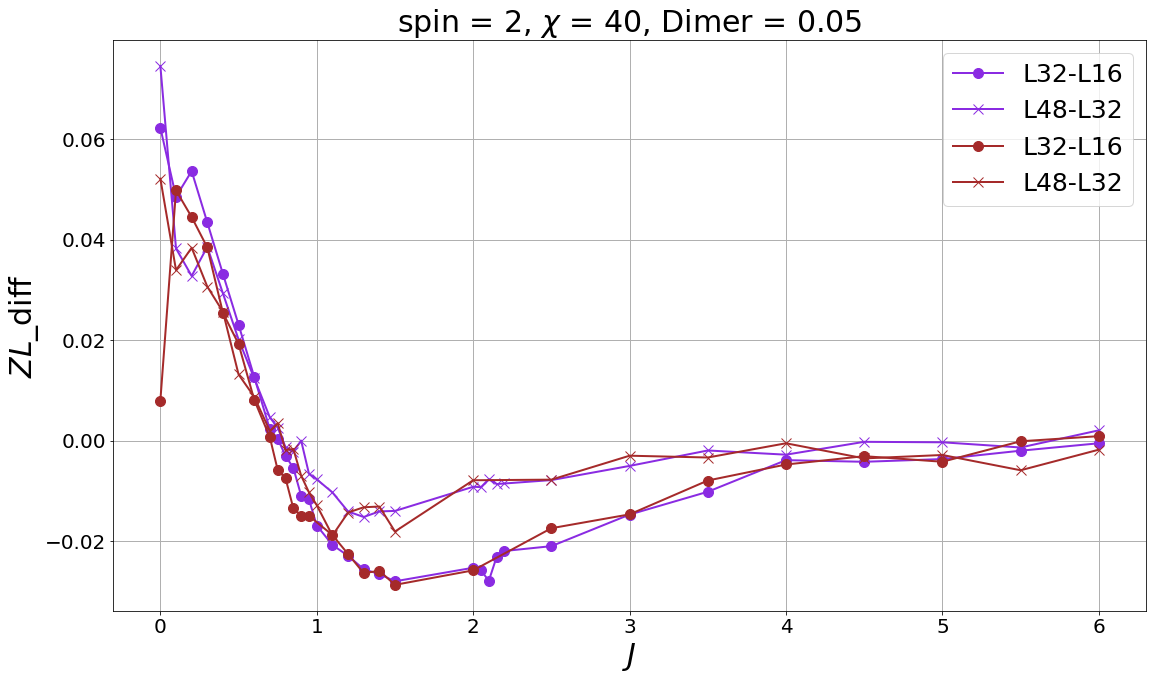

In [177]:
OrderPara = "ZL"

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$_diff', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$_diff', fontsize=font_size)

Ls = [16,32,48]
Dimer = ["Dim000","Dim005"]
Jdis = ALL_Jdis

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    print("\n-------------------- D = "+ str(D) +" --------------------")
    print("         J1", "                  J2")

    for l in range(len(Ls)-1):
        L1 = Ls[l]
        L2 = Ls[l+1]
        f_L1 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_L2 = pd.DataFrame(columns = ['Jdis', 'ZL'])
        f_diff = pd.DataFrame(columns = ['Jdis', 'diff'])
        ignore_num = 0

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])

            file_L1 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L1) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            file_L2 = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis +'/'+ dimer +'/PBC_L'+ str(L2) +'_P'+ str(P) +'_m'+ str(M)\
            +'_'+ OrderPara +'.csv'
            
            if (os.path.exists(file_L1) == False or os.path.exists(file_L2) == False): # Some data is not ok, so we need to ignore it.
                    ignore_num += 1
                    continue
            
            df_L1 = pd.read_csv(file_L1)
            df_L2 = pd.read_csv(file_L2)

            if (OrderPara == "SOP"):
                mean_L1 = {'Jdis':J, 'ZL':-df_L1[Para][0]}
                mean_L2 = {'Jdis':J, 'ZL':-df_L2[Para][0]}
                mean_diff = {'Jdis':J, 'diff':df_L1[Para][0]-df_L2[Para][0]}
            else:
                mean_L1 = {'Jdis':J, 'ZL':df_L1[Para][0]}
                mean_L2 = {'Jdis':J, 'ZL':df_L2[Para][0]}
                mean_diff = {'Jdis':J, 'diff':df_L2[Para][0]-df_L1[Para][0]}

            f_L1.loc[j-ignore_num] = mean_L1
            f_L2.loc[j-ignore_num] = mean_L2
            f_diff.loc[j-ignore_num] = mean_diff

        plt.plot(f_diff['Jdis'], f_diff['diff'], marr[l], color=carr[d], markersize = font_size/3, linewidth = font_size/15, label = 'L%d-L%d' %(L2,L1))

        ids = find_id(f_diff)
        Js, ys = fitting_point(f_L1, f_L2, ids, "Jdis", Para)
        print(("L"+str(L2)+"-"+"L"+str(L1)), Js)

# plt.xscale('log')
# plt.yscale('log')
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
# plt.xlim(0.4, 0.7)
# plt.ylim(0.1, 0.3)
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, Dimer = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = red>L</font>**, look **<font color = yellow>J</font>**, **Order Parameter** vs **<font color = green>D</font>**

In [ ]:
OrderPara = "ZL"   ## Choose SOP or ZL
Ls = [16,32,48,64]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Dimer = ALL_Dimer
Jdis = ["Jdis050"]

if (OrderPara == "SOP"):
    Para = "O^z"
    plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
if (OrderPara == "ZL"):
    Para = "ZL"
    plt.ylabel(r'$ZL$', fontsize=font_size)
    
for l in range(len(Ls)):
    L = Ls[l]

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['Dimer', Para, 'error'])    

        for d in range(len(Dimer)):
            dimer = Dimer[d]
            D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Dimer':D, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Dimer':D, Para:df[Para][0], 'error':df["error"][0]}
                
            dfplt.loc[d] = mean
         
        plt.plot(dfplt['Dimer'], dfplt[Para], marr[l], color=carr[l+j], markersize = font_size/3, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt['Dimer'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$D$', fontsize=font_size)
# plt.xlim(0.9,1.2)  
# plt.ylim(0, 0.1)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = red>L</font>**, look **<font color = green>D</font>**, **Order Parameter** vs **<font color = yellow>J</font>**

In [ ]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [64]
Dimer = ["Dim000","Dim010","Dim020","Dim030","Dim040","Dim050","Dim060","Dim070"]
# Dimer = ["Dim000","Dim002","Dim004","Dim006","Dim008","Dim010"]
Jdis = ALL_Jdis

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

for l in range(len(Ls)):
    L = Ls[l]
    
    for d in range(len(Dimer)):
        dimer = Dimer[d]
        D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
        dfplt = pd.DataFrame(columns = ['Jdis', Para, 'error'])

        for j in range(len(Jdis)):
            jdis = Jdis[j]
            J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
            
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'Jdis':J, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'Jdis':J, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[j] = mean

        plt.plot(dfplt['Jdis'], dfplt[Para], marr[l], color=carr[l+d], markersize = font_size/3, label = 'D=%.2f' %(D))
        plt.errorbar(dfplt['Jdis'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[l+d], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$J$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
plt.xlim(2.5,6)
plt.ylim(0.0, 0.02)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, L = %d' % (spin, M, L), fontsize=font_size)
plt.legend(bbox_to_anchor=(1, 1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## Fix **<font color = green>D</font>**, look **<font color = yellow>J</font>**, **Order Parameter** vs 1/**<font color = red>L</font>**

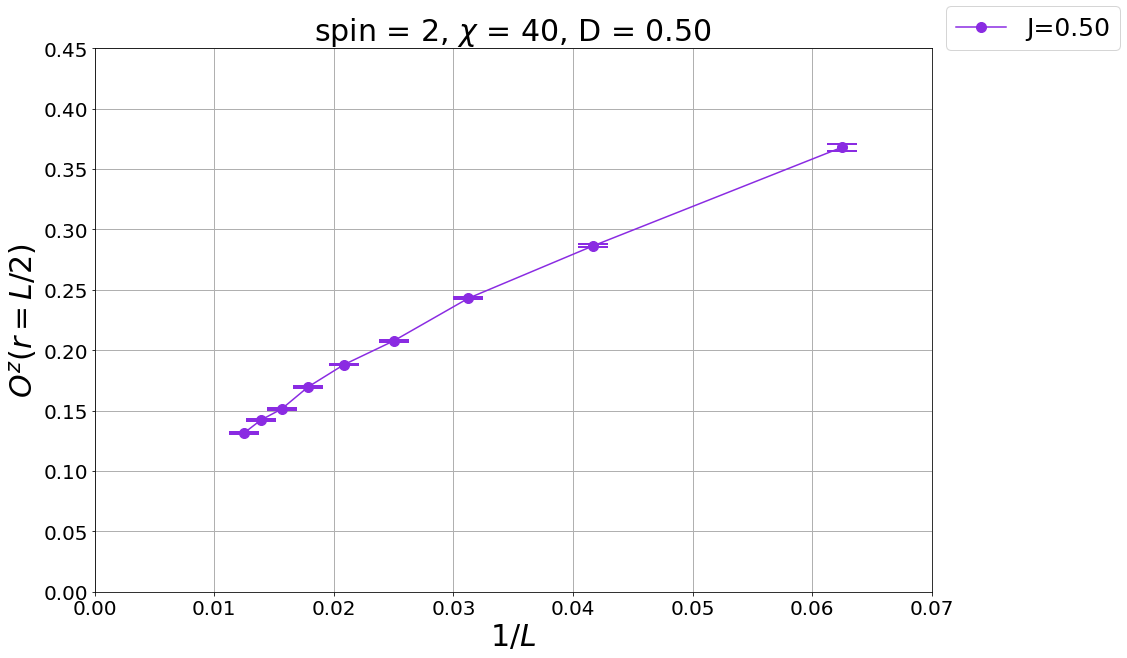

In [64]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
Dimer = ["Dim050"]
Jdis = ["Jdis050"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'


for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])
    
    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])     
        
        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        plt.rcParams['figure.figsize'] = (15, 10)
        plt.plot(dfplt["1/L"], dfplt[Para], marr[j], color=carr[d+j], markersize = font_size/3, label = 'J=%.2f' %(J))
        plt.errorbar(dfplt["1/L"], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=font_size/2, capthick=font_size/15, color=carr[d+j], label=None)
            
plt.xticks(fontsize=font_size/1.5)
plt.yticks(fontsize=font_size/1.5)
plt.xlabel(r'$1/L$', fontsize=font_size)
plt.ylabel(ylable, fontsize=font_size)
plt.xlim(0,0.07)
plt.ylim(0, 0.45)
# plt.xscale('log')
# plt.yscale('log')
plt.grid(linestyle='-', linewidth=1)
plt.title('spin = %s, $\chi$ = %d, D = %.2f' % (spin, M, D), fontsize=font_size)
plt.legend(bbox_to_anchor=(1.24, 1.1), loc = 'best',fontsize=font_size*5/6)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()

## Fix **<font color = yellow>J</font>**, look **<font color = green>D</font>**, **Order Parameter** vs 1/**<font color = red>L</font> (2021/11/25)**

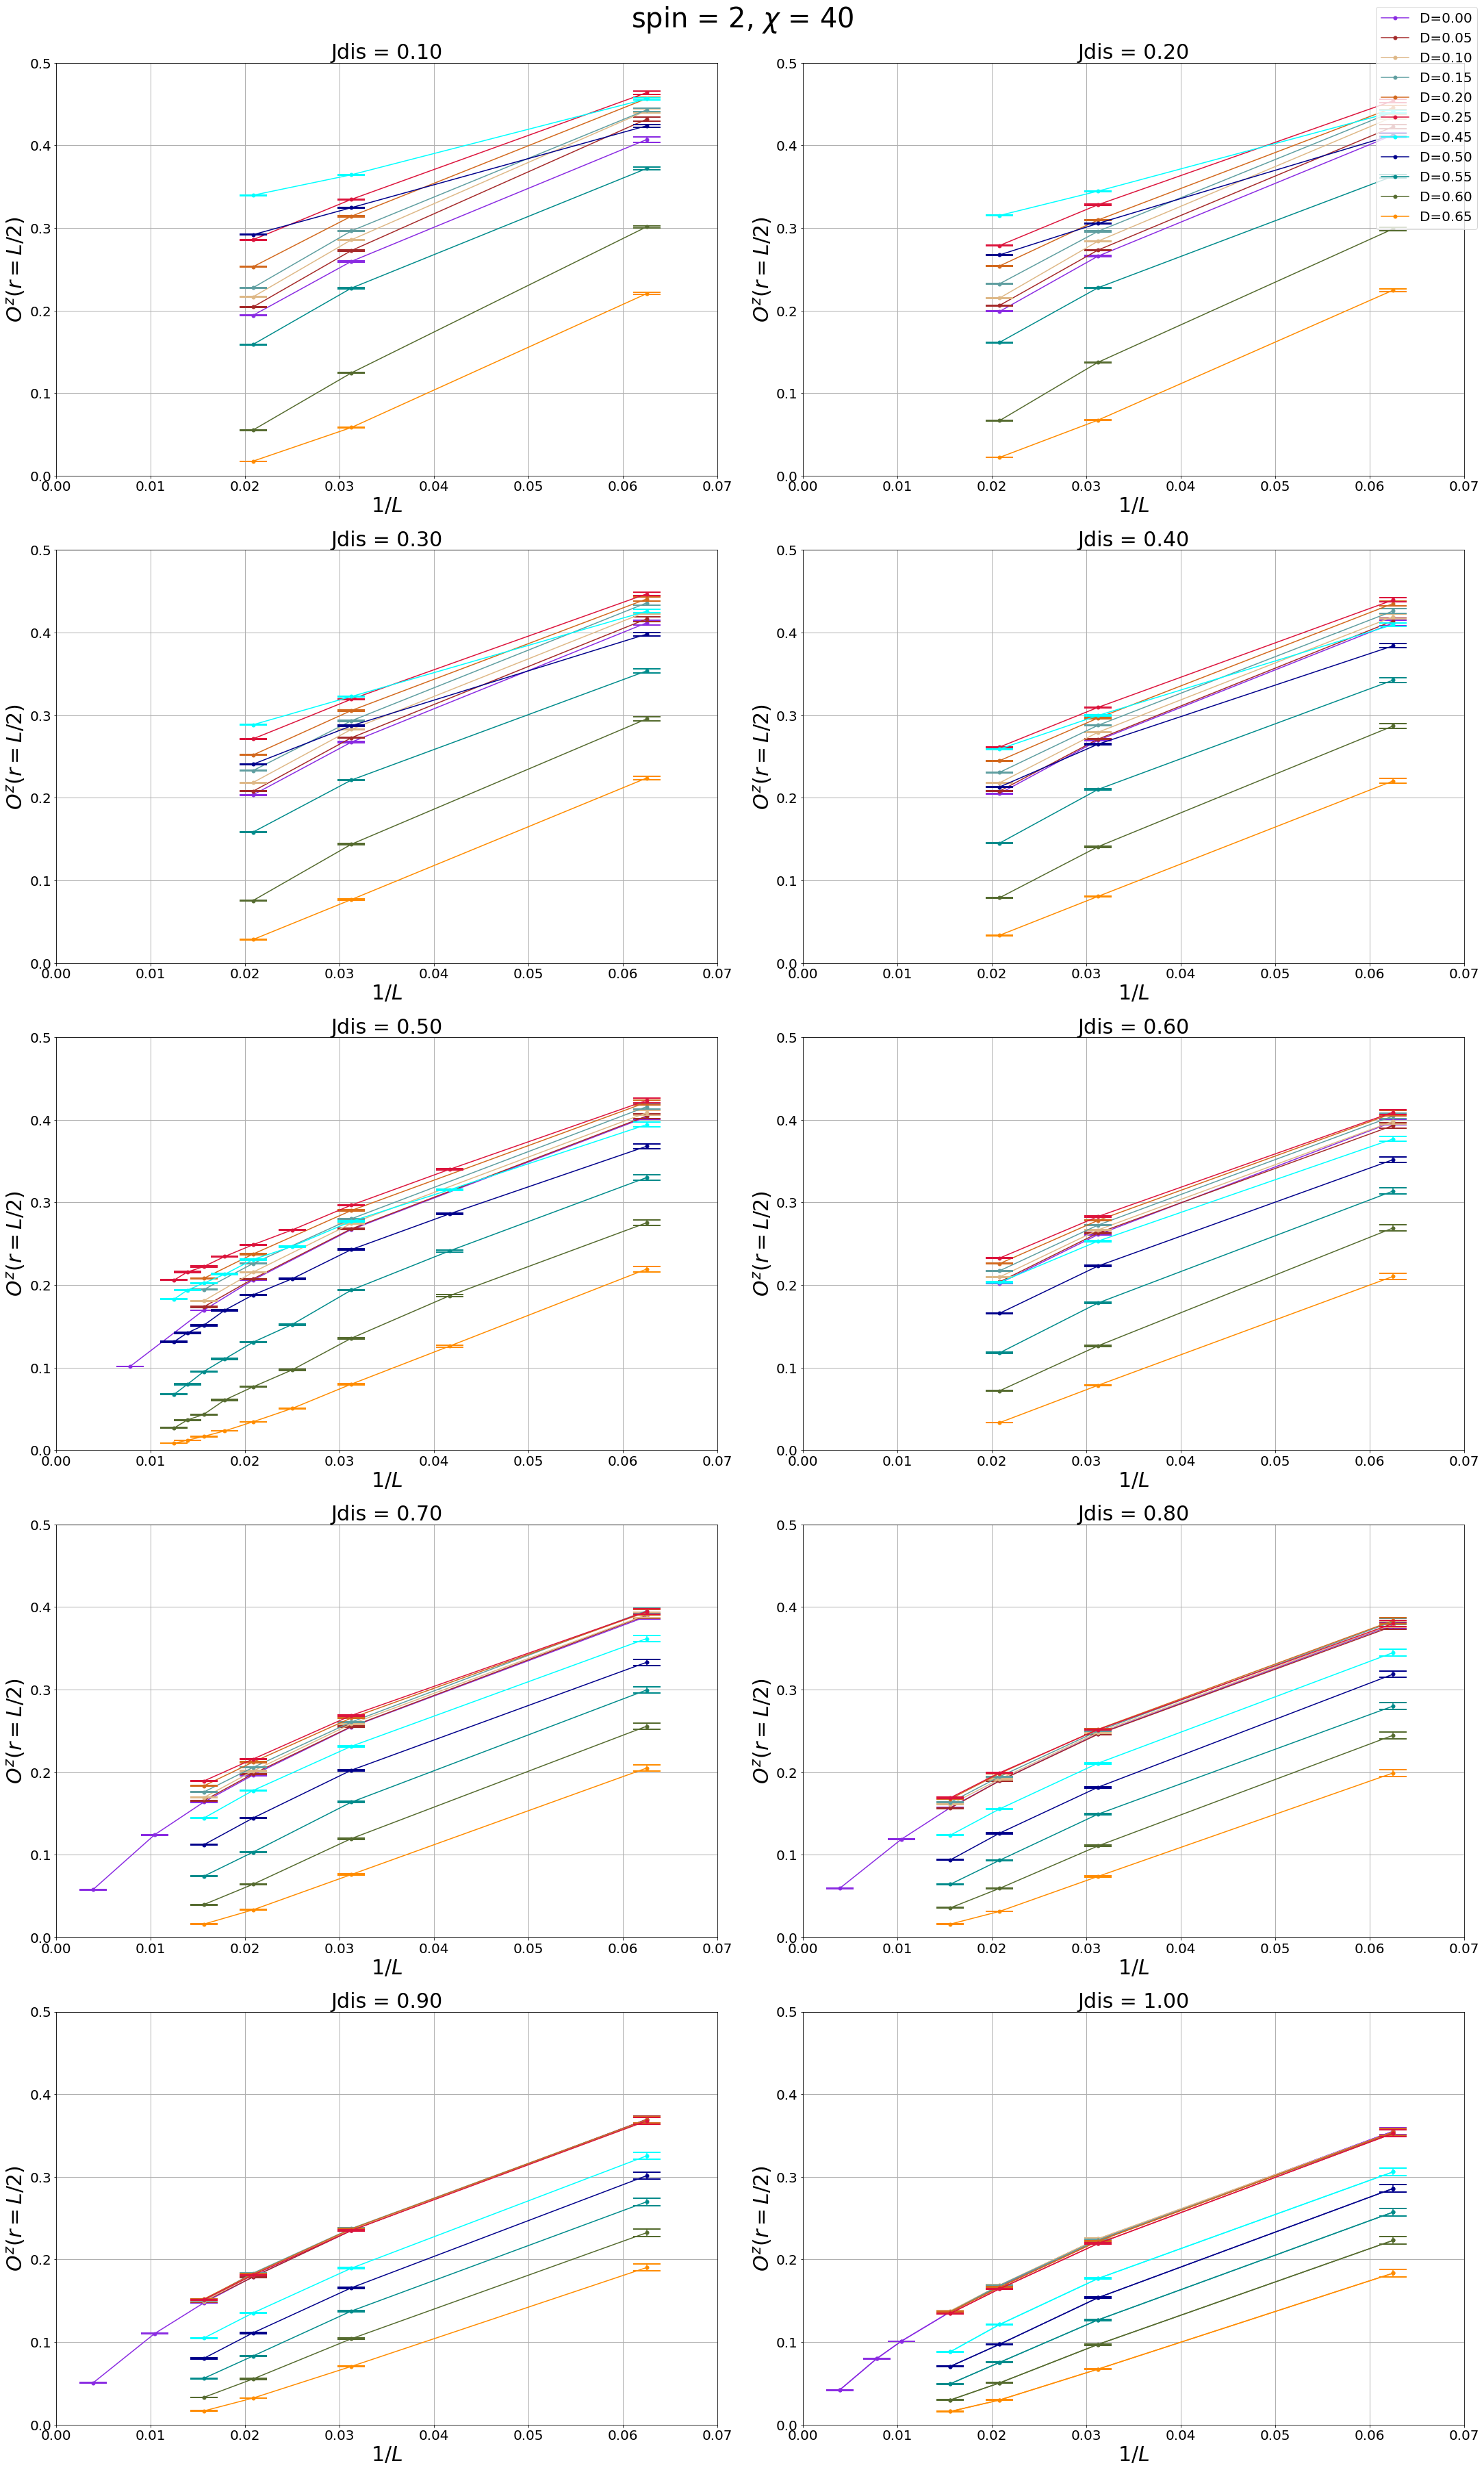

In [98]:
OrderPara = "SOP"  ## Choose SOP or ZL
Ls = [16,24,32,40,48,56,64,72,80,96,128,256]
# Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim030","Dim035","Dim040","Dim045","Dim050","Dim055","Dim060","Dim065","Dim070"]
Dimer = ["Dim000","Dim005","Dim010","Dim015","Dim020","Dim025","Dim045","Dim050","Dim055","Dim060","Dim065"]
Jdis = ["Jdis010","Jdis020","Jdis030","Jdis040","Jdis050","Jdis060","Jdis070","Jdis080","Jdis090","Jdis100"]
# Jdis = ["Jdis000"]

if (OrderPara == "SOP"):
    Para = "O^z"
    # plt.ylabel(r'$O^z(r=L/2)$', fontsize=font_size)
    ylable = r'$O^z(r=L/2)$'
else:
    Para = "ZL"
    # plt.ylabel(r'$ZL$', fontsize=font_size)
    ylable = r'$ZL$'

fig, ax = plt.subplots(5, 2, constrained_layout=True, figsize=(30,50))

for d in range(len(Dimer)):
    dimer = Dimer[d]
    D = float(Dimer[d][3] + '.' + Dimer[d][4] + Dimer[d][5])

    for j in range(len(Jdis)):
        jdis = Jdis[j]
        J = float(Jdis[j][4] + '.' + Jdis[j][5] + Jdis[j][6])
        dfplt = pd.DataFrame(columns = ['1/L', Para, 'error'])  

        for l in range(len(Ls)):
            L = Ls[l]
             
            myfile = '/home/liusf/tSDRG_DataAnalysis/Sorting_data/Spin'+ str(spin) +'_new/metadata/'+ OrderPara +'/'+ jdis + '/' + dimer + '/PBC_L'+ str(L) +'_P' + str(P) + '_m' + str(M)\
+'_'+ OrderPara +'.csv'

            if (os.path.exists(myfile) == False): # Some data is not ok, so we need to ignore it.
                # print(dimer + ' does not exist!!!')
                continue
            
            df = pd.read_csv(myfile)

            if (OrderPara == "SOP" and spin == 2):
                mean = {'1/L':1/L, Para:-1*df[Para][0], 'error':df["error"][0]}
            else:
                mean = {'1/L':1/L, Para:df[Para][0], 'error':df["error"][0]}
            dfplt.loc[l] = mean

        if (j == len(Jdis)-1):
            ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], "o-", color=carr[d], markersize = 5, label = 'D=%.2f' %(D))

        ax[int(j/2)][j-2*int(j/2)].plot(dfplt['1/L'], dfplt[Para], "o-", color=carr[d], markersize = 5)
        ax[int(j/2)][j-2*int(j/2)].errorbar(dfplt['1/L'], dfplt[Para], yerr=dfplt['error'], linestyle='None', capsize=20, capthick=2, color=carr[d], label=None)
        ax[int(j/2)][j-2*int(j/2)].set_xlabel(r'$1/L$', fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].set_ylabel(ylable, fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='x', labelsize=20) 
        ax[int(j/2)][j-2*int(j/2)].tick_params(axis='y', labelsize=20)
        ax[int(j/2)][j-2*int(j/2)].set_title("Jdis = %.2f" %(J), fontsize=30)
        ax[int(j/2)][j-2*int(j/2)].grid(linestyle='-', linewidth=1)
        ax[int(j/2)][j-2*int(j/2)].set_xlim([0,0.07])
        ax[int(j/2)][j-2*int(j/2)].set_ylim([0, 0.5])
        # ax[int(j/2)][j-2*int(j/2)].legend(loc = 'best',fontsize=font_size*5/6)

# plt.xscale('log')
# plt.yscale('log')
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]            
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.suptitle('spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=20)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-D.pdf', format='pdf', dpi=4000)
plt.show()   

## **Phase Diagram** (2021/11/17)

In [ ]:
## 以縱切得到的圖

fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(30,15))

myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_D-J.csv'
df1 = pd.read_csv(myfile)
ax[0].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3)
ax[0].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)

## 以橫切得到的圖
myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_J-D.csv'
df2 = pd.read_csv(myfile)
ax[0].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3)
ax[0].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[0].set_xlabel(r'$D$', fontsize=30)
ax[0].set_ylabel(r'$J$', fontsize=30)
ax[0].tick_params(axis='x', labelsize=20) 
ax[0].tick_params(axis='y', labelsize=20)
ax[0].set_title('old', fontsize=30)
ax[0].grid(linestyle='-', linewidth=1)
ax[0].set_xlim([0, 0.2])                  
ax[0].set_ylim([0, 1])          

myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_D-J_new.csv'
df1 = pd.read_csv(myfile)
ax[1].plot(df1['D'], df1['J'], '-o', color="red", markersize = font_size/3)
ax[1].plot(df1['D'], df1['J2'], '-o', color="red", markersize = font_size/3)

myfile = '/home/liusf/tSDRG_DataAnalysis/PhaseDiagram_J-D_new.csv'
df2 = pd.read_csv(myfile)
ax[1].plot(df2['D'], df2['J'], '-o', color="blue", markersize = font_size/3)
ax[1].plot(df2['D2'], df2['J'], '-o', color="blue", markersize = font_size/3)

ax[1].set_xlabel(r'$D$', fontsize=30)
ax[1].set_ylabel(r'$J$', fontsize=30)
ax[1].tick_params(axis='x', labelsize=20) 
ax[1].tick_params(axis='y', labelsize=20)
ax[1].set_title('new', fontsize=30)
ax[1].grid(linestyle='-', linewidth=1)
# ax[1].set_xlim([0, 0.2])                  
# ax[1].set_ylim([0, 1])               

fig.suptitle('Phase Diagram, spin = %s, $\chi$ = %d' % (spin, M), fontsize=40)
fig.legend(lines, labels, fontsize=15)
# plt.savefig( dimer + '_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
# plt.savefig('L'+ str(L) +'_Spin'+ str(spin) +'_' + BC + '_P'+ str(P) +'_m'+ str(M) +'_Oz-Jdis.pdf', format='pdf', dpi=4000)
plt.show()
